# Desafio XP Investimentos

O desafio envolve prever se uma determinada operação de um cliente em uma data retornou “1” ou “0”. Para isso, são disponibilizados dados transacionais e cadastrais dos clientes.

## Leitura dos dados

Para fazer leitura dos dados utilizamos a livraria [pandas](https://pandas.pydata.org) do Python.

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
pessoas = pd.read_csv('data/_pessoas.csv', index_col=['ID'], parse_dates=['data'])
train = pd.read_csv('data/_transacao_train.csv', parse_dates=['data'])

## Modelagem do DataFrame

Usamos [pandas.DataFrame.join](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) para juntar os dados cadastrais dos clientes com os dados transacionais.

In [3]:
df = train.join(pessoas, on='ID', how='left', lsuffix='_t')

In [4]:
df.shape

(1939676, 45)

In [5]:
df.head()

,ID,data_t,categoria,var10_t,retorno,var1,grupo,var2,data,var3,...,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38
0,cli_100165,2022-07-17,tipo5,type 542,0,tipo2,group 17304,tipo2,2022-03-25,tipo40,...,False,False,False,False,False,False,False,False,False,0
1,cli_100900,2022-07-17,tipo5,type 551,0,tipo2,group 17304,tipo2,2022-07-16,tipo12,...,False,False,False,False,False,False,False,False,False,17
2,cli_101418,2022-07-17,tipo5,type 1340,1,tipo2,group 7011,tipo3,2022-02-08,tipo4,...,False,False,False,True,False,True,False,True,True,87
3,cli_101879,2022-07-17,tipo3,type 3,1,tipo2,group 17376,tipo3,2020-12-31,tipo40,...,True,True,True,True,True,True,True,True,True,100
4,cli_101879,2022-07-17,tipo3,type 3,1,tipo2,group 17376,tipo3,2020-12-31,tipo40,...,True,True,True,True,True,True,True,True,True,100


## Dados faltantes

Vamos conferir se o dataframe construido possui dados faltantes

In [6]:
df = df[df.retorno.notnull()]
df.shape

(1939676, 45)

## Análise de dados categóricos

Para simplificar a análise vamos remover as colunas que possuem mais de 10 categorias

In [7]:
def cat_cols(df):
    return set(df.columns) - set(df._get_numeric_data().columns)


for col in cat_cols(df):
    n = len(df[col].unique())
    if n > 10:
        df.drop([col], axis=1, inplace=True)

In [8]:
columns = list(cat_cols(df))
df = pd.get_dummies(df, columns=columns)
df.shape

(1939676, 74)

## Análise de correlações

Selecionaremos as variáveis que tenham uma correlação absoluta com a variável retorno maior do que **0.1**

In [9]:
corr_matrix = df.corr()
corr_matrix = corr_matrix[abs(corr_matrix['retorno']) > 0.1]

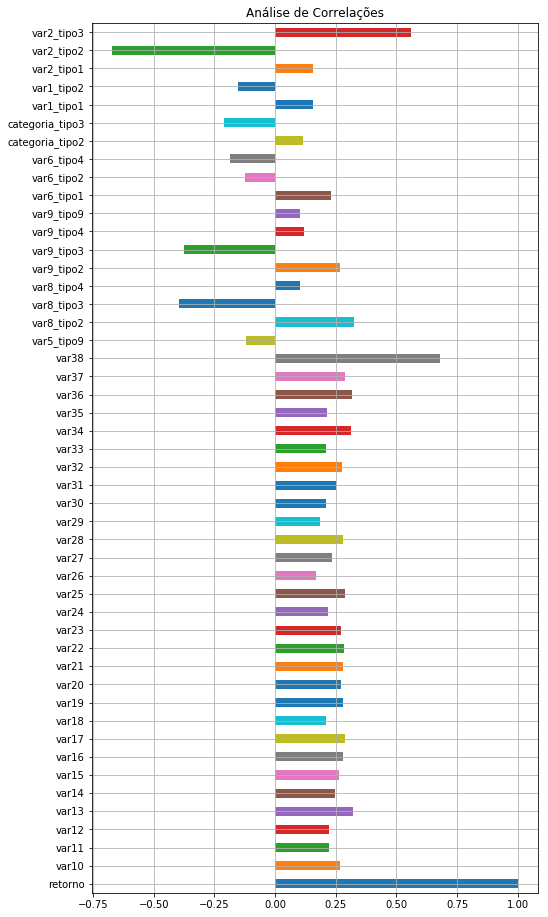

In [10]:
corr_matrix.retorno.plot(kind='barh', grid=True, title="Análise de Correlações", figsize=(8,16));

In [11]:
good_variables = corr_matrix.retorno.index
df = df[good_variables]
df.shape

(1939676, 48)

## Modelo de classificação

Utilizamos a livraria [scikit-learn](http://scikit-learn.org) para criar o modelo de classificação.

In [12]:
y = df.retorno
X = df.drop(['retorno'], axis=1)

In [13]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(max_depth=10, random_state=42)

from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='most_frequent')

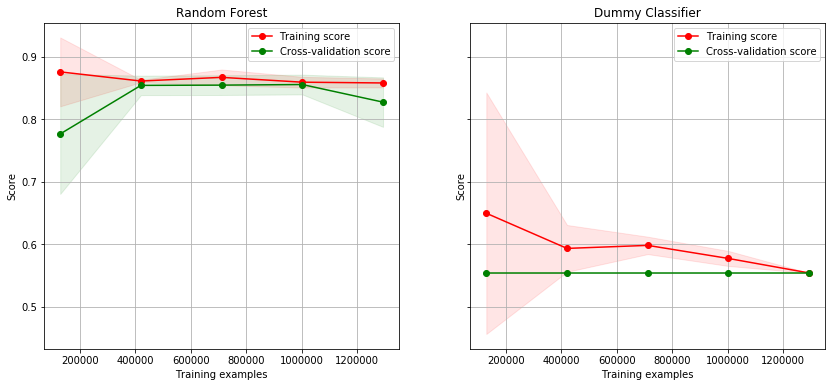

In [14]:
import scikitplot as skplt

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
skplt.estimators.plot_learning_curve(model, X, y, ax=ax[0], title='Random Forest')
skplt.estimators.plot_learning_curve(dummy, X, y, ax=ax[1], title='Dummy Classifier');

In [15]:
model.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

## Previsões para os dados de teste

In [16]:
test = pd.read_csv('data/_transacao_test.csv', parse_dates=['data'])

df = test.join(pessoas, on='ID', how='left', lsuffix='_t')
df = pd.get_dummies(df, columns=columns)

X = df[good_variables.drop(['retorno'])]

## Resultado final

O vetor com as previsões realizadas é **output_test**

In [17]:
output_test = model.predict(X)
np.savetxt('output_test.txt', output_test, fmt='%d')